In [1]:
!pip install -q cleverhans
!pip install -q plot_keras_history
!pip install -q keras-tuner

In [2]:
import scipy.io
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from scipy.linalg import norm

from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras.models import load_model

from sklearn.metrics import mean_squared_error
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent,fast_gradient_method
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method
from tqdm.keras import TqdmCallback
import numpy as np

import seaborn as sns
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense

HYPARAMETER_TUNING = False
TRAIN_MODEL = False
GOOGLE_COLAB = True

PROJECT_FOLDER = ''

In [3]:
if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive")
    PROJECT_FOLDER = '/content/gdrive/My Drive/ds/IRS/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
X = pd.read_csv(PROJECT_FOLDER + 'xtrain_32_10000.csv', header=None)
X = X.values

Y = pd.read_csv(PROJECT_FOLDER + 'ytrain_32_10000.csv', header=None)
Y = Y.values

M = X.shape[1]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [6]:
def get_model(mult_factor):
  model = Sequential()
  model.add(Dense(int(M*mult_factor), input_dim=M, activation='relu'))
  model.add(Dense(int(2*M*mult_factor), activation='relu'))
  model.add(Dense(int(4*M*mult_factor), activation='relu'))
  model.add(Dense(int(4*M*mult_factor), activation='relu'))
  model.add(Dense(Y.shape[1], activation='relu'))

  model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

  return model

In [7]:
model = get_model(1.0)
se = tf.keras.callbacks.EarlyStopping(monitor='val_mse',patience=150,verbose=1,
                                      restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=500, verbose=0,validation_split=0.2,
                    callbacks=[se,TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

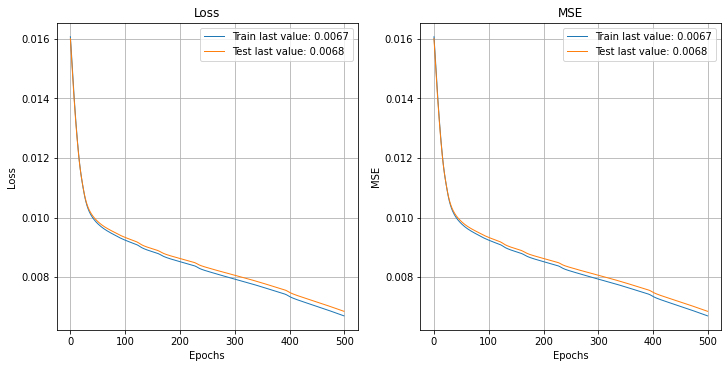

In [8]:
plot_history(history)
plt.show()

In [9]:
model.save(PROJECT_FOLDER + 'model.hdf5')

# Convert the model Cleverhans compatible model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

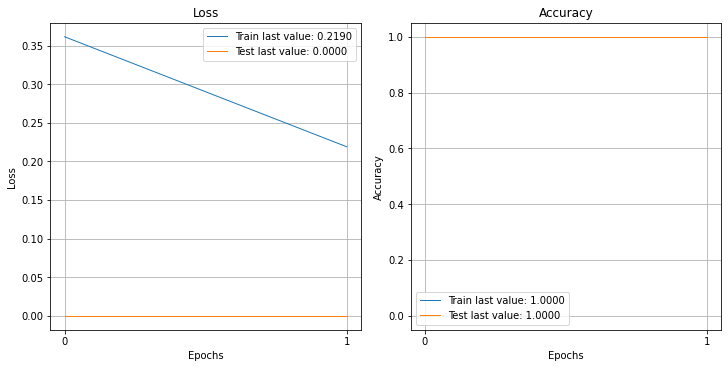

In [10]:
model_copy = tf.keras.models.clone_model(model)
for layer in model_copy.layers:
  layer.trainable = False

model_copy.add(Dense(2, activation='softmax'))
model_copy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

y_dummy = np.zeros((X_train.shape[0],2))
mid_range = np.int(X_train.shape[0] / 2.0)
y_dummy[0:mid_range,0]= 1.0

history = model_copy.fit(X_train, y_dummy, epochs=2, verbose=0,
              callbacks=[TqdmCallback(verbose=1)],batch_size=256,
              validation_split=0.33, shuffle= True)
plot_history(history)
plt.show()

## Attack the model

In [11]:
from itertools import product
from random import shuffle

logits_model = tf.keras.Model(model_copy.input, model_copy.output)
attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD']

eps_vals = [0.01, 0.1, 0.3, 0.5, 0.7, 0.8]

params_list = list(product(eps_vals,attacks))
shuffle(params_list)

mal_diff_distance_list = []
real_mse_list = []
mal_mse_list = []
mal_predicted_diff_list = []
attack_name_list = []
eps_val_list = []

#for i in tqdm(range(X_test.shape[0])):
for _ in tqdm(range(5)):
  i = np.random.randint(0,X_test.shape[0])
  test_input = X_test[i:i+1,:].astype(np.float32)

  for eps_val, attack in params_list:
        if attack == 'FGSM':
          mal_input = fast_gradient_method(logits_model, test_input, eps=eps_val/20.0, norm=np.inf,
                                            clip_min=test_input.min(),clip_max=test_input.max(),
                                            targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'BIM':
          mal_input = basic_iterative_method(logits_model, test_input, eps=eps_val, norm=np.inf,
                                              #clip_min=test_input.min(),clip_max=test_input.max(),
                                              eps_iter=0.01,nb_iter=2000,
                                              targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'MIM':
          mal_input = momentum_iterative_method(logits_model, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=2000,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'PGD':
          mal_input = projected_gradient_descent(logits_model, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=2000,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'CW':
          mal_input = carlini_wagner_l2(logits_model, test_input,
                                targeted=False, #y=y_output,
                                batch_size=512, confidence=10.0,
                                abort_early=False, max_iterations=1000,
                                clip_min=test_input.min(),clip_max=test_input.max())
          
        mal_diff = mal_input - test_input
        mal_diff_distance = norm(mal_diff, ord = np.inf)
        mal_diff_distance_list.append(mal_diff_distance)

        real_output = y_test[i:i+1,:]
        test_output = model.predict(test_input)
        real_mse = mean_squared_error(real_output,test_output)
        real_mse_list.append(real_mse)

        malicious_test_output = model.predict(mal_input)
        mal_mse = mean_squared_error(real_output,malicious_test_output)
        mal_mse_list.append(mal_mse)

        mal_predicted_diff = malicious_test_output - test_output
        mal_predicted_diff = norm(mal_predicted_diff, ord = np.inf)
        mal_predicted_diff_list.append(mal_predicted_diff)

        attack_name_list.append(attack)
        eps_val_list.append(eps_val)

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
df_result = pd.DataFrame({'Malicious_Distance':mal_diff_distance_list,
                          'Real_Predicted_MSE':real_mse_list,
                          'Malicious_Predicted_MSE':mal_mse_list,
                          'MalOut_RealOut_Diff':mal_predicted_diff_list,
                          'Attack':attack_name_list,
                          'eps':eps_val_list})
df_result

,Malicious_Distance,Real_Predicted_MSE,Malicious_Predicted_MSE,MalOut_RealOut_Diff,Attack,eps
0,281.642853,0.007904,0.010725,20.035965,MIM,0.8
1,81.320984,0.007904,0.008754,9.123885,PGD,0.1
2,85.205322,0.007904,0.008792,8.614745,MIM,0.1
3,14.572388,0.007904,0.007941,1.382549,FGSM,0.3
4,196.103790,0.007904,0.010890,17.165459,PGD,0.5
...,...,...,...,...,...,...
115,198.043716,0.006840,0.008432,18.537216,PGD,0.3
116,34.424145,0.006840,0.006948,3.128234,FGSM,0.7
117,207.769989,0.006840,0.007591,15.462641,BIM,0.3
118,268.659790,0.006840,0.007416,20.827293,BIM,0.8


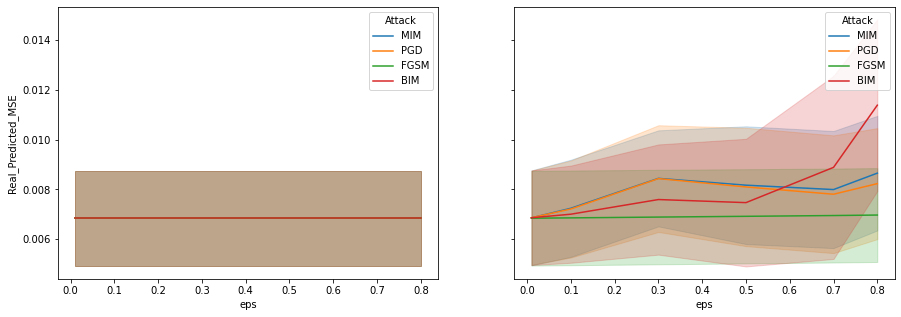

In [13]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))
sns.lineplot(x='eps', y='Real_Predicted_MSE', hue='Attack', ci='sd', estimator="median",
             data=df_result, ax=ax[0])

sns.lineplot(x='eps', y='Malicious_Predicted_MSE', hue='Attack', ci='sd', estimator="median",
             data=df_result, ax=ax[1])

#Defensive Distillation

In [14]:
!rm -f util_defdistill.py
!wget -q https://raw.githubusercontent.com/ocatak/6g_MIMO_security_distillation/main/util_defdistill.py

from util_defdistill import Distiller

STUDENT_MODEL_MULTIPLICATION = 0.5
TEACHER_MODEL_MULTIPLICATION = 1.0

student_model = get_model(STUDENT_MODEL_MULTIPLICATION)
teacher_model = get_model(TEACHER_MODEL_MULTIPLICATION)

es_teacher = EarlyStopping(monitor='val_loss', 
                          patience=150, 
                          min_delta=0.001,
                          verbose=1,
                          restore_best_weights=True,
                          mode='min')

# Train and evaluate teacher on data.
hist_teacher = teacher_model.fit(X_train, y_train, 
              epochs=100000,
              verbose=0,batch_size=1024,
              callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
              validation_data=(X_test, y_test))

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 405.
Epoch 555: early stopping


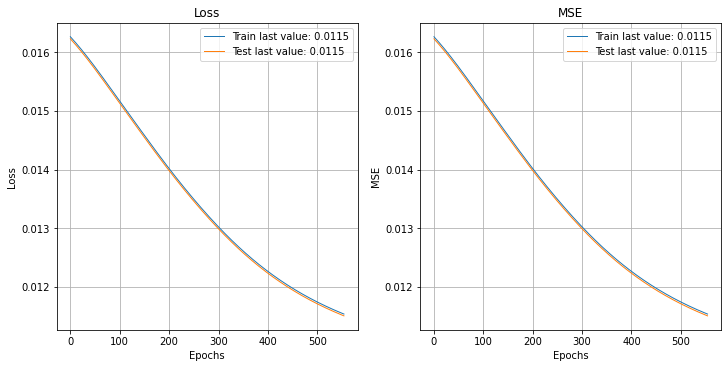

In [15]:
plot_history(hist_teacher.history)
plt.show()

In [16]:
import keras
distiller = Distiller(student=student_model, teacher=teacher_model)
loss_fn = keras.losses.MeanSquaredError()

distiller.compile(optimizer='adam',
                            metrics=['mse'],
                            student_loss_fn=loss_fn,
                            distillation_loss_fn=keras.losses.KLDivergence(),
                            alpha=0.1,
                            temperature=20)

es = EarlyStopping(monitor='val_student_loss', 
                   patience=20, 
                   #min_delta=0.000001,
                   verbose=1,
                   restore_best_weights=True,
                   mode='min')

hist_distill = distiller.fit(X_train, y_train, 
                              epochs=10000,
                              verbose=0,
                              callbacks=[es,TqdmCallback(verbose=1, desc='DL training')],
                              validation_data=(X_test, y_test))

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 37.
Epoch 57: early stopping


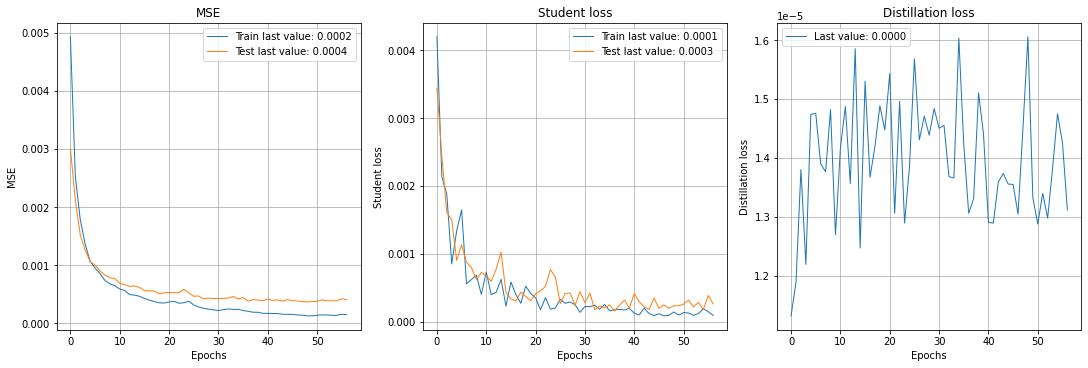

In [17]:
plot_history(hist_distill.history)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

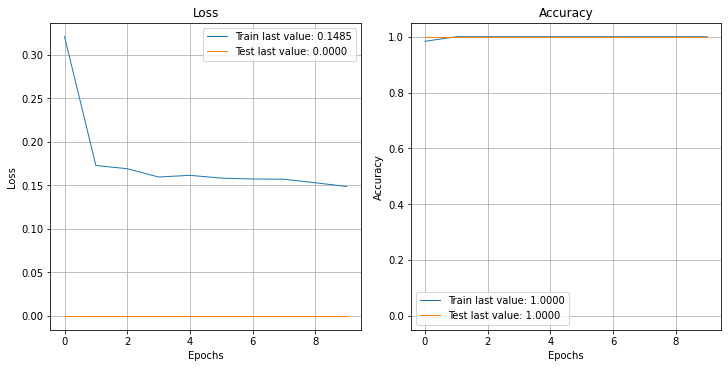

In [18]:
from keras.layers import Dense, Conv2D, Flatten
student_copy = tf.keras.models.clone_model(distiller.student)
for layer in student_copy.layers:
    	layer.trainable = False

student_copy.add(Dense(2, activation='softmax'))
student_copy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

y_dummy = np.zeros((X_train.shape[0],2))
mid_range = np.int(X_train.shape[0] / 2.0)
y_dummy[0:mid_range,0]= 1.0
history = student_copy.fit(X_train, y_dummy, epochs=2, verbose=0,
              callbacks=[TqdmCallback(verbose=1)],batch_size=128,
              validation_split=0.33, shuffle= True)
plot_history(history)
plt.show()

In [19]:
from itertools import product
from random import shuffle

logits_model_student = tf.keras.Model(student_copy.input, student_copy.output)
attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD']

eps_vals = [0.01, 0.1, 0.3, 0.5, 0.7, 0.8]

params_list = list(product(eps_vals,attacks))
shuffle(params_list)

distil_mal_diff_distance_list = []
distil_real_mse_list = []
distil_mal_mse_list = []
distil_mal_predicted_diff_list = []
distil_attack_name_list = []
distil_eps_val_list = []

#for i in tqdm(range(X_test.shape[0])):
for _ in tqdm(range(5)):
  i = np.random.randint(0,X_test.shape[0])
  test_input = X_test[i:i+1,:].astype(np.float32)

  for eps_val, attack in params_list:
        if attack == 'FGSM':
          mal_input = fast_gradient_method(logits_model, test_input, eps=eps_val/20.0, norm=np.inf,
                                            clip_min=test_input.min(),clip_max=test_input.max(),
                                            targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'BIM':
          mal_input = basic_iterative_method(logits_model, test_input, eps=eps_val, norm=np.inf,
                                              #clip_min=test_input.min(),clip_max=test_input.max(),
                                              eps_iter=0.01,nb_iter=2000,
                                              targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'MIM':
          mal_input = momentum_iterative_method(logits_model, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=2000,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'PGD':
          mal_input = projected_gradient_descent(logits_model, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=2000,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'CW':
          mal_input = carlini_wagner_l2(logits_model, test_input,
                                targeted=False, #y=y_output,
                                batch_size=512, confidence=10.0,
                                abort_early=False, max_iterations=1000,
                                clip_min=test_input.min(),clip_max=test_input.max())
          
        mal_diff = mal_input - test_input
        mal_diff_distance = norm(mal_diff, ord = np.inf)
        distil_mal_diff_distance_list.append(mal_diff_distance)

        real_output = y_test[i:i+1,:]
        test_output = distiller.student.predict(test_input)
        real_mse = mean_squared_error(real_output,test_output)
        distil_real_mse_list.append(real_mse)

        malicious_test_output = distiller.student.predict(mal_input)
        mal_mse = mean_squared_error(real_output,malicious_test_output)
        distil_mal_mse_list.append(mal_mse)

        mal_predicted_diff = malicious_test_output - test_output
        mal_predicted_diff = norm(mal_predicted_diff, ord = np.inf)
        distil_mal_predicted_diff_list.append(mal_predicted_diff)

        distil_attack_name_list.append(attack)
        distil_eps_val_list.append(eps_val)

  0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
df_result_distill = pd.DataFrame({'Malicious_Distance':distil_mal_diff_distance_list,
                          'Real_Predicted_MSE':distil_real_mse_list,
                          'Malicious_Predicted_MSE':distil_mal_mse_list,
                          'MalOut_RealOut_Diff':distil_mal_predicted_diff_list,
                          'Attack':distil_attack_name_list,
                          'eps':distil_eps_val_list})
df_result_distill

,Malicious_Distance,Real_Predicted_MSE,Malicious_Predicted_MSE,MalOut_RealOut_Diff,Attack,eps
0,90.840012,0.000406,0.000408,3.866464,BIM,0.10
1,205.466568,0.000406,0.000596,8.485148,PGD,0.30
2,9.849995,0.000406,0.000404,0.130710,BIM,0.01
3,334.129913,0.000406,0.000455,9.804306,BIM,0.70
4,5.057673,0.000406,0.000408,0.110424,FGSM,0.10
...,...,...,...,...,...,...
115,197.000610,0.000243,0.008216,38.448257,PGD,0.80
116,192.487305,0.000243,0.007124,34.984123,MIM,0.30
117,259.968994,0.000243,0.008748,40.053532,MIM,0.50
118,9.880083,0.000243,0.000237,0.343055,MIM,0.01


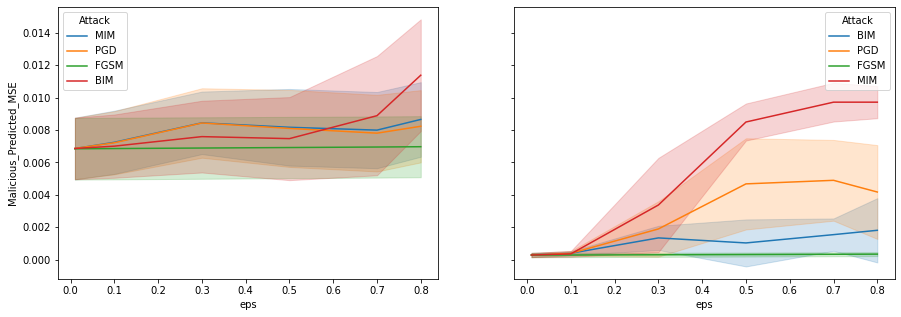

In [21]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))
sns.lineplot(x='eps', y='Malicious_Predicted_MSE', hue='Attack', ci='sd', estimator="median",
             data=df_result, ax=ax[0])

sns.lineplot(x='eps', y='Malicious_Predicted_MSE', hue='Attack', ci='sd', estimator="median",
             data=df_result_distill, ax=ax[1])